In [484]:
from astropy.io import fits
import numpy as np
import scipy.stats
from scipy.stats import norm
from astropy.coordinates import Angle
import astropy.units as u
import matplotlib.pyplot as plt

In [485]:
def fits_data_index(fits_file: str):
    '''Given a FITS file, return the index of the file where the data array is'''

    file_index = 0

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    info = file[file_index]
    data = info.data
    while data is None:
        #going through the indices of file to find the array
        try:
            file_index += 1
            info = file[file_index]
            data = info.data
        except:
            print(f'Error in locating data index of {fits_file}')

    return file_index

In [486]:
def region_stats(fits_file: str, center: list = [], radius: list = [], invert: bool = False):
    '''Given a FITS file, list of center coordinates in units of pixels,
    list of radii in units of arcsec (include measurements within this radius of the center),
    and Boolean of whether to invert (if True, becomes exclude instead of include),
    return a dictionary with floats of the maximum flux (in Jy), coordinates of field center (in pixels),
    coordinates of maximum flux (in pixels), rms (in Jy), beam size (in arcsec^2),
    x axis length (in arcsec), and y axis length (in arcsec) in the specified region.
    If no center given, will eventually default to center of ((length of x-axis)/2, (length of y-axis)/2), rounded up.
    '''

    if center != [] and len(center) != len(radius):
        raise IndexError ('Center list and radius list lengths do not match')

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]
    data = info.data

    #getting dimensions for array
    try:
        dims = data.shape
        x_dim = dims[1]
        y_dim = dims[2]
    except:
        print('Data dimension error')

    x_dist_array = np.tile(np.arange(x_dim),(y_dim, 1)) #array of each pixel's horizontal distance (in pixels) from y-axis
    y_dist_array = x_dist_array.T #array of each pixel's vertical distance (in pixels) from x-axis

    #keep center pixel coordinates if specified, set to default if unspecified
    center_pix = center
    field_center = (round(x_dim/2), round(y_dim/2))
    if center == []:
        center_pix = [field_center]
        if len(radius) > 1:
            center_pix = center_pix * len(radius)

    #find units of axes
    x_unit = info.header['CUNIT1']
    y_unit = info.header['CUNIT2']

    #find cell size (units of arcsec)
    x_cell_size = (Angle(info.header['CDELT1'], x_unit)).to(u.arcsec)
    y_cell_size = (Angle(info.header['CDELT2'], y_unit)).to(u.arcsec)
    y_cell_size.to(u.arcsec)

    #find major axis (units of arcsec), minor axis (units of arcsec), beam size (units of arcsec^2)
    beam_size = ((np.pi/4) * info.header['BMAJ'] * info.header['BMIN'] * Angle(1, x_unit) * Angle(1, y_unit) / np.log(2)).to(u.arcsec**2)

    #find axis sizes
    x_axis_size = info.header['NAXIS1'] * x_cell_size
    y_axis_size = info.header['NAXIS2'] * y_cell_size

    #distance from center array
    dist_from_center =((((x_dist_array - center_pix[0][0])*x_cell_size)**2 + ((y_dist_array - center_pix[0][1])*y_cell_size)**2)**0.5)

    #boolean mask and apply
    mask = (dist_from_center <= radius[0] * u.arcsec)
    if len(center) > 1:
        for j in range(1, len(center)):
            dist_from_center = ((((x_dist_array - center_pix[j][0])*x_cell_size)**2 + ((y_dist_array - center_pix[j][1])*y_cell_size)**2)**0.5)
            mask = np.logical_or(mask, (dist_from_center <= radius[j] * u.arcsec))

    if invert:
        mask = np.logical_not(mask)

    masked_data = data[0][mask]

    #get peak, rms, beam_size values
    try:
        peak = float(max(masked_data))
    except ValueError:
        print('No values after mask applied. Check inclusion and exclusion radii.')

    #find coordinates of peak
    peak_pix = np.where(data[0] == peak)
    x = peak_pix[1][0]
    y = peak_pix[0][0]
    peak_coord = (int(x_dist_array[0][x]), int(y_dist_array[y][0]))

    rms = float((np.var(masked_data))**0.5)

    stats = {'peak': peak, 'field_center': field_center, 'peak_coord': peak_coord, 'rms': rms, 'beam_size': float(beam_size / (u.arcsec**2)),\
              'x_axis': float(x_axis_size / u.arcsec), 'y_axis': float(y_axis_size / u.arcsec)}

    return stats

In [487]:
def incl_excl_data(fits_file: str, center: list = []):
    '''Given a FITS file and (optional) list of tuples of center coordinates in units of arcsec,
    return a dictionary with the field center coordinates as tuple, peak flux value of the inclusion area, coordinates of this peak as tuple,
    peak flux value of the exclusion area, coordinates of this peak as tuple, rms value of the exclusion area,
    number of measurements in the inclusion area, and number of measurements in the exclusion area of the specified circle.
    '''

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]

    #get radius, inclusion, exclusion lists for interior and exterior
    radius = [float((info.header['BMAJ'] * (Angle(1, info.header['CUNIT1'])).to(u.arcsec) / u.arcsec) + 5)] #major axis + 5 arcsec
    if len(center) > 1:
        radius = radius + ([radius[0] - 5.0] * (len(center) - 1))

    #get info on inclusion and exclusion regions
    int_info = region_stats(fits_file = fits_file, radius = radius, center = center)
    ext_info = region_stats(fits_file = fits_file, radius = radius, center = center, invert=True)

    #getting values for peak, rms, axis lengths, beam size
    info_dict = {}
    info_dict['int_peak_val'] = int_info['peak']
    info_dict['field_center'] = int_info['field_center']
    info_dict['int_peak_coord'] = int_info['peak_coord']
    info_dict['ext_peak_coord'] = ext_info['peak_coord']
    info_dict['ext_peak_val'] = ext_info['peak']
    info_dict['rms_val'] = ext_info['rms']
    x_axis = int_info['x_axis']
    y_axis = int_info['y_axis']
    beam_size = int_info['beam_size']

    #calculating number of measurements in inclusion and exclusion regions
    incl_area = np.pi * ((radius[0]**2) + ((radius[0] - 5.0)**2) * (len(center)- 1))
    excl_area = x_axis * y_axis - incl_area
    info_dict['n_incl_meas'] = incl_area / beam_size
    info_dict['n_excl_meas'] = excl_area / beam_size

    return info_dict

In [ ]:
def meas_rms_prob(fits_file: str, center: list = [], rms: float = None, reps: bool = False, recursion: bool = True):
    '''Given a FITS file, (optional) list of tuples of center coordinates in units of arcsec,
    (optional) rms value, and (optional) choice to use recursion, return a list of dictionaries.
    The first dictionary contains the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    with noise being the measured rms in the exclusion area.
    If the external probability is less than 0.001, there will be subsequent dictionaries
    that contain the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    with noise being the measured rms in the exclusion area,
    but the included region is expanded to include the highest excluded peak of the previous excluded region
    and the excluded region now excludes that highest peak.
    '''
    info = incl_excl_data(fits_file, center)
    if rms is not None:
        info['rms_val'] = rms

    if reps: #keeping int_peak_val and int_peak coord in the original search area
        initial_info = incl_excl_data(fits_file, [center[0]])
        info['int_peak_val'] = initial_info['int_peak_val']
        info['int_peak_coord'] = initial_info['int_peak_coord']

    int_peak = info['int_peak_val']
    ext_peak = info['ext_peak_val']
    rms = info['rms_val']
    n_incl = info['n_incl_meas']
    n_excl = info['n_excl_meas']

    #calculate error for rms
    rms_err = rms * (n_excl)**(-1/2)

    #create normal distributions from rms and error for rms
    uncert = np.linspace(-5 * rms_err, 5 * rms_err, 100)
    uncert_pdf = norm.pdf(uncert, loc = 0, scale = rms_err)

    #sum and normalize to find probabilities
    prob_dict = info
    prob_dict['int_prob'] = float(sum((norm.cdf((-1 * int_peak)/(rms + uncert)) * n_incl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['ext_prob'] = float(sum((norm.cdf((-1 * ext_peak)/(rms + uncert)) * n_excl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['int_snr'] = float(int_peak / rms)
    prob_dict['ext_snr'] = float(ext_peak / rms)

    prob_list = [prob_dict]

    if prob_dict['ext_prob'] < 0.001 and recursion:
        reps = True
        if center == []:
            new_center = [info['field_center'], info['ext_peak_coord']]
        else:
            center.append(info['ext_peak_coord'])
            new_center = center
        new_list = meas_rms_prob(fits_file, new_center, rms = None, reps = reps, recursion = True)
        prob_list.extend(new_list)

    #using better rms value for calculating probability of peak when just looking in initial area
    elif len(prob_list) > 1:
        new_list = meas_rms_prob(fits_file, center = [prob_list[0]['field_center']], rms = prob_list[-1]['rms_val'], \
                                     reps = False, recursion = False)
        new_list.extend(prob_list[1:])
        prob_list = new_list

    return prob_list

In [489]:
def calc_rms_prob(prob_list: list):
    '''Given a list output from meas_rms_prob(), return the list output with an appended dictionary
    that contains the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    calculated rms, calculated interior peak to noise ratio, and calculated exterior peak to noise ratio
    with noise being the calculated rms in the exclusion area based on the expected probability of the peak value in the exclusion area.
    '''
    info = prob_list[-1]

    int_peak_val = info['int_peak_val']
    ext_peak_val = info['ext_peak_val']
    n_incl_meas = info['n_incl_meas']
    n_excl_meas = info['n_excl_meas']

    excl_sigma = -1 * norm.ppf(1/n_excl_meas)
    rms_val = ext_peak_val / excl_sigma

    prob_dict= {}

    prob_dict['calc_rms_val'] = float(rms_val)
    prob_dict['calc_int_prob'] = float(norm.cdf((-1 * int_peak_val)/(rms_val))) * n_incl_meas
    prob_dict['calc_ext_prob'] = float(norm.cdf((-1 * ext_peak_val)/(rms_val))) * n_excl_meas
    prob_dict['calc_int_snr'] = float(int_peak_val / rms_val)
    prob_dict['calc_ext_snr'] = float(excl_sigma)

    prob_list.append(prob_dict)

    return prob_list

In [ ]:
def summary(fits_file: str, info_list: bool = True, plot: bool = True):
    '''Given a FITS file, (optional) choice to return a list of information, and (optional) choice to show a plot,
    return a list of source information if requested and a plot of source information if requested.
    '''
    m_info = meas_rms_prob(fits_file)
    info = (calc_rms_prob(meas_rms_prob(fits_file)))

    if plot:
        image_data = fits.getdata(fits_file)
        shape = image_data.shape

        if len(shape) > 2:
            image_data = image_data[0]

        x_coords = [m_info[0]['int_peak_coord'][0]]
        y_coords = [m_info[0]['int_peak_coord'][1]]

        print(len(m_info))
        print(m_info)
        if len(m_info) > 1:
            for i in range(len(m_info)-1):
                x_coords.append(m_info[i]['ext_peak_coord'][0])
                y_coords.append(m_info[i]['ext_peak_coord'][1])

        plt.plot(x_coords, y_coords, 'o')
        plt.imshow(image_data)
        plt.colorbar()

    if info_list:
        return info

{'int_peak_val': 12.789649963378906, 'field_center': (68, 68), 'int_peak_coord': (67, 67), 'ext_peak_coord': (69, 31), 'ext_peak_val': 0.11062327027320862, 'rms_val': 0.013562027364969254, 'n_incl_meas': 13.850108975152835, 'n_excl_meas': 405.41847107232974, 'int_prob': 0.0, 'ext_prob': 3.1113825641187164e-12, 'int_snr': 943.0485294856874, 'ext_snr': 8.156838745138412}
{'int_peak_val': 12.789649963378906, 'field_center': (68, 68), 'int_peak_coord': (67, 67), 'ext_peak_coord': (65, 103), 'ext_peak_val': 0.10841279476881027, 'rms_val': 0.012968845665454865, 'n_incl_meas': 21.855713305506473, 'n_excl_meas': 397.4128667419761, 'int_prob': 0.0, 'ext_prob': 8.324504395533311e-13, 'int_snr': 986.182602006493, 'ext_snr': 8.35947913680472}
{'int_peak_val': 12.789649963378906, 'field_center': (68, 68), 'int_peak_coord': (67, 67), 'ext_peak_coord': (96, 124), 'ext_peak_val': 0.047967977821826935, 'rms_val': 0.012375887483358383, 'n_incl_meas': 25.858515470683297, 'n_excl_meas': 393.4100645767993,

[{'int_peak_val': 12.789649963378906,
  'field_center': (68, 68),
  'int_peak_coord': (67, 67),
  'ext_peak_coord': (69, 31),
  'ext_peak_val': 0.11062327027320862,
  'rms_val': 0.013562027364969254,
  'n_incl_meas': 13.850108975152835,
  'n_excl_meas': 405.41847107232974,
  'int_prob': 0.0,
  'ext_prob': 3.1113825641187164e-12,
  'int_snr': 943.0485294856874,
  'ext_snr': 8.156838745138412},
 {'int_peak_val': 12.789649963378906,
  'field_center': (68, 68),
  'int_peak_coord': (67, 67),
  'ext_peak_coord': (65, 103),
  'ext_peak_val': 0.10841279476881027,
  'rms_val': 0.012968845665454865,
  'n_incl_meas': 21.855713305506473,
  'n_excl_meas': 397.4128667419761,
  'int_prob': 0.0,
  'ext_prob': 8.324504395533311e-13,
  'int_snr': 986.182602006493,
  'ext_snr': 8.35947913680472},
 {'int_peak_val': 12.789649963378906,
  'field_center': (68, 68),
  'int_peak_coord': (67, 67),
  'ext_peak_coord': (96, 124),
  'ext_peak_val': 0.047967977821826935,
  'rms_val': 0.012375887483358383,
  'n_incl

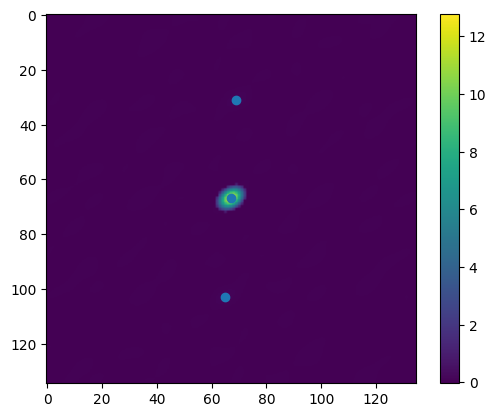

In [491]:
for i in range(len(meas_rms_prob('3c279.fits'))):
    print(meas_rms_prob('3c279.fits')[i])
summary('3c279.fits')

In [493]:
fits_list = ['ngc5044.fits', '1407+2827.fits', '3c245.fits', 'sdssj152527.48+050029.9.fits',\
             'sdssj155636.40+415250.5.fits', '3c270.1.fits']
for f in range(len(fits_list)):
    print(fits_list[f])
    print('meas')
    m = meas_rms_prob(fits_file = fits_list[f])
    print(m)
    print('calc')
    print(calc_rms_prob(m))
    print()

ngc5044.fits
meas
[{'int_peak_val': 0.04268083721399307, 'field_center': (66, 66), 'int_peak_coord': (65, 67), 'ext_peak_coord': (58, 29), 'ext_peak_val': 0.0032760933972895145, 'rms_val': 0.0007852913695387542, 'n_incl_meas': 17.254855280999937, 'n_excl_meas': 530.218023138264, 'int_prob': 0.0, 'ext_prob': 0.01024094531504168, 'int_snr': 54.35031998258421, 'ext_snr': 4.1718189252655975}]
calc
[{'int_peak_val': 0.04268083721399307, 'field_center': (66, 66), 'int_peak_coord': (65, 67), 'ext_peak_coord': (58, 29), 'ext_peak_val': 0.0032760933972895145, 'rms_val': 0.0007852913695387542, 'n_incl_meas': 17.254855280999937, 'n_excl_meas': 530.218023138264, 'int_prob': 0.0, 'ext_prob': 0.01024094531504168, 'int_snr': 54.35031998258421, 'ext_snr': 4.1718189252655975}, {'calc_rms_val': 0.0011310046016103502, 'calc_int_prob': 0.0, 'calc_ext_prob': 0.9999999999999988, 'calc_int_snr': 37.7371030614934, 'calc_ext_snr': 2.8966225182682175}]

1407+2827.fits
meas
[{'int_peak_val': 0.004832044243812561

In [494]:
fits_list = ['0510+180.fits', 'hd283323.fits', 'l1551-51.fits', 'bd+21 584.fits', 'hd28354.fits', \
'uranus.fits', '3c111.fits', 'bllac.fits', 'hd283572.fits', 'v652per.fits', '3c279.fits', '0854+201.fits']
for f in range(len(fits_list)):
    print(fits_list[f])
    print('meas')
    m = meas_rms_prob(fits_file = fits_list[f])
    print(m)
    print('calc')
    print(calc_rms_prob(m))
    print()

0510+180.fits
meas
[{'int_peak_val': 1.2661728858947754, 'field_center': (74, 74), 'int_peak_coord': (73, 73), 'ext_peak_coord': (88, 144), 'ext_peak_val': 0.004458718933165073, 'rms_val': 0.0011129066115245223, 'n_incl_meas': 15.846333421593453, 'n_excl_meas': 541.9397707389757, 'int_prob': 0.0, 'ext_prob': 0.02049997535471924, 'int_snr': 1137.7171029295084, 'ext_snr': 4.006372940005512}]
calc
[{'int_peak_val': 1.2661728858947754, 'field_center': (74, 74), 'int_peak_coord': (73, 73), 'ext_peak_coord': (88, 144), 'ext_peak_val': 0.004458718933165073, 'rms_val': 0.0011129066115245223, 'n_incl_meas': 15.846333421593453, 'n_excl_meas': 541.9397707389757, 'int_prob': 0.0, 'ext_prob': 0.02049997535471924, 'int_snr': 1137.7171029295084, 'ext_snr': 4.006372940005512}, {'calc_rms_val': 0.0015356483778069566, 'calc_int_prob': 0.0, 'calc_ext_prob': 0.9999999999999999, 'calc_int_snr': 824.5200556282185, 'calc_ext_snr': 2.90347647130818}]

hd283323.fits
meas
[{'int_peak_val': 0.001534036360681057,

In [495]:
def no_rec_meas_rms_prob(fits_file: str, center: list = [], rms=None):
    '''Given a FITS file, (optional) list of tuples of center coordinates in units of arcsec,
    and (optional) maximum number of repetitions, return a list of dictionaries.
    The first dictionary contains the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    with noise being the measured rms in the exclusion area.
    If the external probability is less than 0.001, there will be subsequent dictionaries
    that contain the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    with noise being the measured rms in the exclusion area,
    but the included region is expanded to include the highest excluded peak of the previous excluded region
    and the excluded region now excludes that highest peak.
    '''
    info = incl_excl_data(fits_file, center)
    if rms is not None:
        info['rms_val'] = rms

    int_peak = info['int_peak_val']
    ext_peak = info['ext_peak_val']
    rms = info['rms_val']
    n_incl = info['n_incl_meas']
    n_excl = info['n_excl_meas']

    #calculate error for rms
    rms_err = rms * (n_excl)**(-1/2)

    #create normal distributions from rms and error for rms
    uncert = np.linspace(-5 * rms_err, 5 * rms_err, 100)
    uncert_pdf = norm.pdf(uncert, loc = 0, scale = rms_err)

    #sum and normalize to find probabilities
    prob_dict = info
    prob_dict['int_prob'] = float(sum((norm.cdf((-1 * int_peak)/(rms + uncert)) * n_incl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['ext_prob'] = float(sum((norm.cdf((-1 * ext_peak)/(rms + uncert)) * n_excl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['int_snr'] = float(int_peak / rms)
    prob_dict['ext_snr'] = float(ext_peak / rms)

    return prob_dict

In [496]:
print(no_rec_meas_rms_prob('l1551-51.fits'))
print(no_rec_meas_rms_prob('l1551-51.fits', [(74,74),(98,58)])) #center and ext peak

{'int_peak_val': 0.0015234688762575388, 'field_center': (74, 74), 'int_peak_coord': (76, 89), 'ext_peak_coord': (98, 58), 'ext_peak_val': 0.0032458838541060686, 'rms_val': 0.0006422644946724176, 'n_incl_meas': 16.296536740186614, 'n_excl_meas': 562.9108697408742, 'int_prob': 0.1471118156320168, 'ext_prob': 0.00019992246378200653, 'int_snr': 2.372027239392352, 'ext_snr': 5.053811756730548}
{'int_peak_val': 0.0032458838541060686, 'field_center': (74, 74), 'int_peak_coord': (98, 58), 'ext_peak_coord': (43, 62), 'ext_peak_val': 0.002294371370226145, 'rms_val': 0.0006354488432407379, 'n_incl_meas': 22.61654186189848, 'n_excl_meas': 556.5908646191624, 'int_prob': 6.1981254553259405e-06, 'ext_prob': 0.09686522016920755, 'int_snr': 5.108017566846644, 'ext_snr': 3.610631122601523}


In [497]:
print(no_rec_meas_rms_prob('l1551-51.fits'))
new_dict = no_rec_meas_rms_prob('l1551-51.fits', [(74,74),(98,58)])
better_dict = no_rec_meas_rms_prob('l1551-51.fits', rms=new_dict['rms_val'])
print(better_dict)
print(new_dict)

{'int_peak_val': 0.0015234688762575388, 'field_center': (74, 74), 'int_peak_coord': (76, 89), 'ext_peak_coord': (98, 58), 'ext_peak_val': 0.0032458838541060686, 'rms_val': 0.0006422644946724176, 'n_incl_meas': 16.296536740186614, 'n_excl_meas': 562.9108697408742, 'int_prob': 0.1471118156320168, 'ext_prob': 0.00019992246378200653, 'int_snr': 2.372027239392352, 'ext_snr': 5.053811756730548}
{'int_peak_val': 0.0015234688762575388, 'field_center': (74, 74), 'int_peak_coord': (76, 89), 'ext_peak_coord': (98, 58), 'ext_peak_val': 0.0032458838541060686, 'rms_val': 0.0006354488432407379, 'n_incl_meas': 16.296536740186614, 'n_excl_meas': 562.9108697408742, 'int_prob': 0.13742983839440767, 'ext_prob': 0.0001534607648474924, 'int_snr': 2.3974689583003572, 'ext_snr': 5.108017566846644}
{'int_peak_val': 0.0032458838541060686, 'field_center': (74, 74), 'int_peak_coord': (98, 58), 'ext_peak_coord': (43, 62), 'ext_peak_val': 0.002294371370226145, 'rms_val': 0.0006354488432407379, 'n_incl_meas': 22.616

In [498]:
print(no_rec_meas_rms_prob('3c279.fits'))
print(no_rec_meas_rms_prob('3c279.fits', [(68,68),(69,31)])) #center and ext peak
print(no_rec_meas_rms_prob('3c279.fits', [(68,68),(69,31),(65,103)])) #center and 2 ext peaks

{'int_peak_val': 12.789649963378906, 'field_center': (68, 68), 'int_peak_coord': (67, 67), 'ext_peak_coord': (69, 31), 'ext_peak_val': 0.11062327027320862, 'rms_val': 0.013562027364969254, 'n_incl_meas': 13.850108975152835, 'n_excl_meas': 405.41847107232974, 'int_prob': 0.0, 'ext_prob': 3.1113825641187164e-12, 'int_snr': 943.0485294856874, 'ext_snr': 8.156838745138412}
{'int_peak_val': 12.789649963378906, 'field_center': (68, 68), 'int_peak_coord': (67, 67), 'ext_peak_coord': (65, 103), 'ext_peak_val': 0.10841279476881027, 'rms_val': 0.012968845665454865, 'n_incl_meas': 21.855713305506473, 'n_excl_meas': 397.4128667419761, 'int_prob': 0.0, 'ext_prob': 8.324504395533311e-13, 'int_snr': 986.182602006493, 'ext_snr': 8.35947913680472}
{'int_peak_val': 12.789649963378906, 'field_center': (68, 68), 'int_peak_coord': (67, 67), 'ext_peak_coord': (96, 124), 'ext_peak_val': 0.047967977821826935, 'rms_val': 0.012375887483358383, 'n_incl_meas': 25.858515470683297, 'n_excl_meas': 393.4100645767993,

In [499]:
print(no_rec_meas_rms_prob('0854+201.fits'))
print(no_rec_meas_rms_prob('0854+201.fits', [(74,74),(76,39)])) #center and ext peak
print(no_rec_meas_rms_prob('0854+201.fits', [(74,74),(76,39),(71,107)])) #center and 2 ext peaks

{'int_peak_val': 4.247470378875732, 'field_center': (74, 74), 'int_peak_coord': (73, 73), 'ext_peak_coord': (76, 39), 'ext_peak_val': 0.035033728927373886, 'rms_val': 0.007197387982159853, 'n_incl_meas': 17.574406834267915, 'n_excl_meas': 624.5114802361488, 'int_prob': 0.0, 'ext_prob': 0.0005205572521241459, 'int_snr': 590.1405328438492, 'ext_snr': 4.867561539576844}
{'int_peak_val': 4.247470378875732, 'field_center': (74, 74), 'int_peak_coord': (73, 73), 'ext_peak_coord': (71, 107), 'ext_peak_val': 0.03389593958854675, 'rms_val': 0.007134626619517803, 'n_incl_meas': 23.932930684512367, 'n_excl_meas': 618.1529563859044, 'int_prob': 0.0, 'ext_prob': 0.0008944137626342051, 'int_snr': 595.3318380048316, 'ext_snr': 4.750905884243403}
{'int_peak_val': 4.247470378875732, 'field_center': (74, 74), 'int_peak_coord': (73, 73), 'ext_peak_coord': (99, 51), 'ext_peak_val': 0.03073205053806305, 'rms_val': 0.007070926483720541, 'n_incl_meas': 27.11219260963459, 'n_excl_meas': 614.9736944607821, 'int

In [500]:
for key, value in no_rec_meas_rms_prob('3c279.fits', [(68,68),(69,31),(65,103)]).items():
    print(key,value)

int_peak_val 12.789649963378906
field_center (68, 68)
int_peak_coord (67, 67)
ext_peak_coord (96, 124)
ext_peak_val 0.047967977821826935
rms_val 0.012375887483358383
n_incl_meas 25.858515470683297
n_excl_meas 393.4100645767993
int_prob 0.0
ext_prob 0.02658367725997804
int_snr 1033.4329542488892
ext_snr 3.8759222630561685
